In [1]:
import pandas as pd
import numpy as np
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder as LE
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
from catboost import CatBoostClassifier

print("All libraries loaded")

All libraries loaded


In [2]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [3]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data = data[data['Tipo'] != 'PR']
data.dropna(subset=['Tipo'], inplace=True)

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Tipo'],inplace=True)


data['TipoDeDiagnostico'] = data['Diagnostico '].map({'CN': 1, 'MCI': 2, 'PDD': 3})
data.drop(columns=['Diagnostico '], inplace=True)

data = data.dropna()

conteo_clases = data['TipoDeDiagnostico'].value_counts()

print(conteo_clases)
print(data.info())

TipoDeDiagnostico
1    128
3     35
2     33
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area 

In [4]:
X = data.drop(columns=['TipoDeDiagnostico'])
y = data['TipoDeDiagnostico']

X = X.dropna()
y = y[X.index]

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 196 entries, 0 to 225
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           196 non-null    float64
 1   Ángulo manecillas 2pm             196 non-null    float64
 2   Ángulo manecillas 11am            196 non-null    float64
 3   Números detectados correctamente  196 non-null    int64  
 4   Números con error espacial        196 non-null    int64  
 5   Números algo detectado            196 non-null    int64  
 6   Total numeros detectados          196 non-null    int64  
 7   Puntuacion contorno               196 non-null    int64  
 8   Puntuacion manecillas             196 non-null    int64  
 9   Puntuacion numeros                196 non-null    int64  
 10  puntuacion final                  196 non-null    int64  
 11  Area Circulo                      196 non-null    float64
 12  Circularidad 

Datos de entrenamiento: (166, 21), Datos de validación: (72, 21), Datos de prueba ciega: (40, 21)


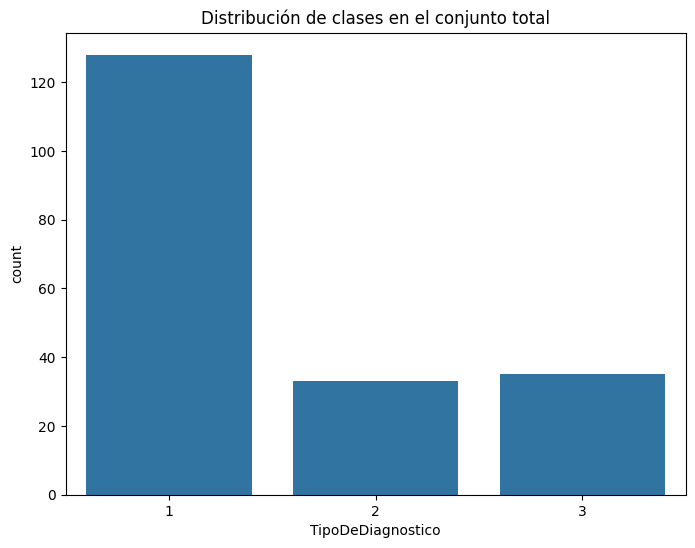

TipoDeDiagnostico
1    128
3     35
2     33
Name: count, dtype: int64


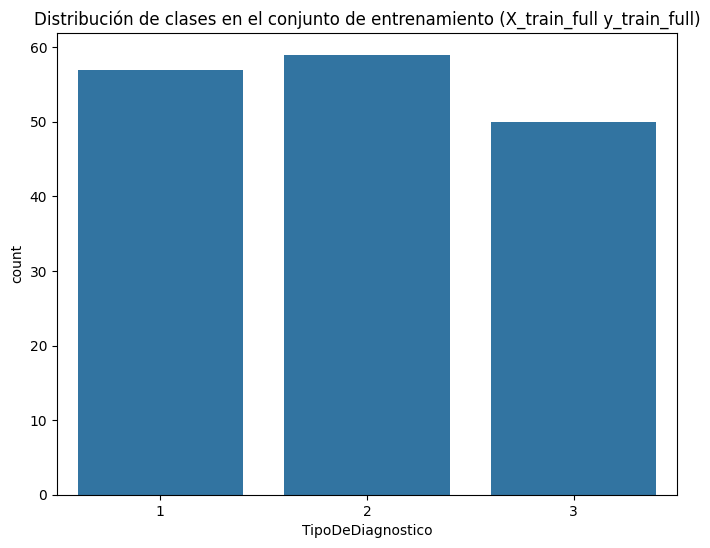

TipoDeDiagnostico
2    59
1    57
3    50
Name: count, dtype: int64


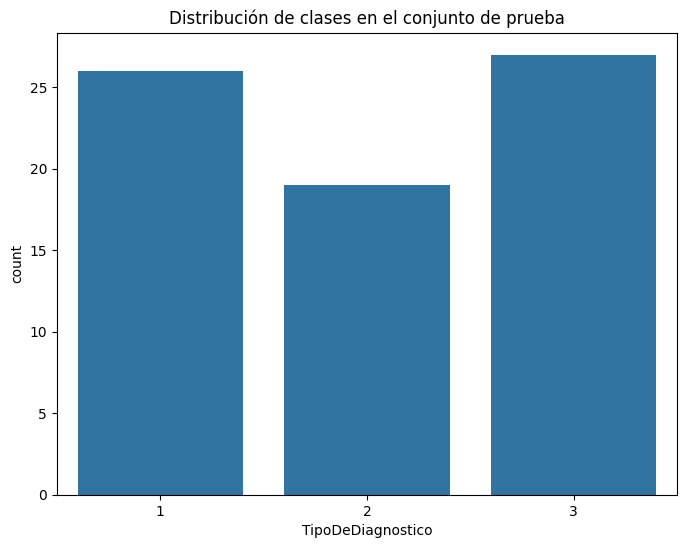

TipoDeDiagnostico
3    27
1    26
2    19
Name: count, dtype: int64


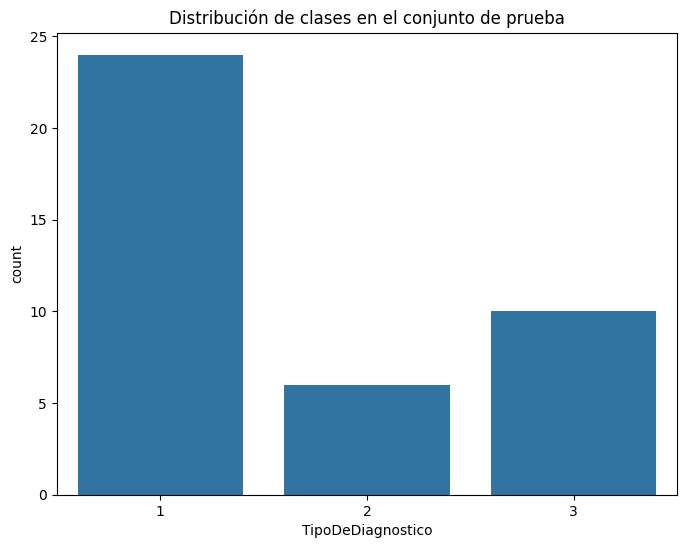

TipoDeDiagnostico
1    24
3    10
2     6
Name: count, dtype: int64


In [5]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

smote = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: {X_test_full.shape}, Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_full)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba')
plt.show()
print(y_test_blind.value_counts())

MODELO LGBM

In [6]:
lgb_model = lgb.LGBMClassifier(random_state=42)

param_dist_lgbm = {
    'num_leaves': [31, 50, 100, 150, 200],
    'max_depth': [-1, 5, 10, 15, 20],
    'learning_rate': [0.1, 0.01, 0.05, 0.005, 0.001],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [20, 30, 50],
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10]
}


random_search_lgbm = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgbm,
    n_iter=50,  
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)


In [7]:
random_search_lgbm.fit(X_train_full, y_train_full)

y_val_pred = random_search_lgbm.best_estimator_.predict(X_test_full)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 596
[LightGBM] [Info] Number of data points in the train set: 166, number of used features: 20
[LightGBM] [Info] Start training from score -1.068937
[LightGBM] [Info] Start training from score -1.034450
[LightGBM] [Info] Start training from score -1.199965
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

In [8]:
y_val_pred_lgmb = random_search_lgbm.predict(X_test_full)

print("Evaluación en el conjunto de validación con el modelo lgbm:")
print(f"Accuracy: {accuracy_score(y_test_full, y_val_pred_lgmb):.4f}")
print(f"Precision: {precision_score(y_test_full, y_val_pred_lgmb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_full, y_val_pred_lgmb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_full, y_val_pred_lgmb, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_full, y_val_pred_lgmb))


Evaluación en el conjunto de validación con el modelo lgbm:
Accuracy: 0.6806
Precision: 0.7108
Recall: 0.6806
F1 Score: 0.6916

Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.64      0.62      0.63        26
           2       0.46      0.58      0.51        19
           3       0.96      0.81      0.88        27

    accuracy                           0.68        72
   macro avg       0.68      0.67      0.67        72
weighted avg       0.71      0.68      0.69        72



In [9]:
y_test_blind_pred_lgbm = random_search_lgbm.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega con el modelo lgbm:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")


Evaluación en conjunto de prueba ciega con el modelo lgbm:
Accuracy: 0.6250
Precision: 0.7132
Recall: 0.6250
F1 Score: 0.6560


In [10]:
y_test_pred_lgmb = random_search_lgbm.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original con el modleo lgbm:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred_lgmb):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")


Evaluación en conjunto train original con el modleo lgbm:
Accuracy: 0.6987
Precision: 0.7504
Recall: 0.6987
F1 Score: 0.7151


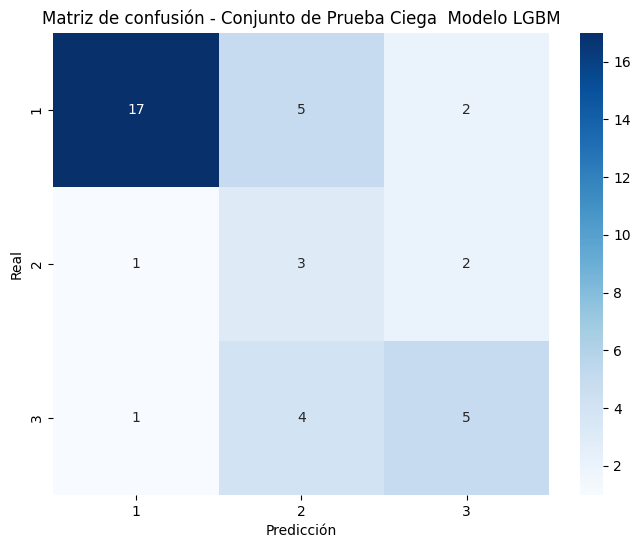

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega  Modelo LGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


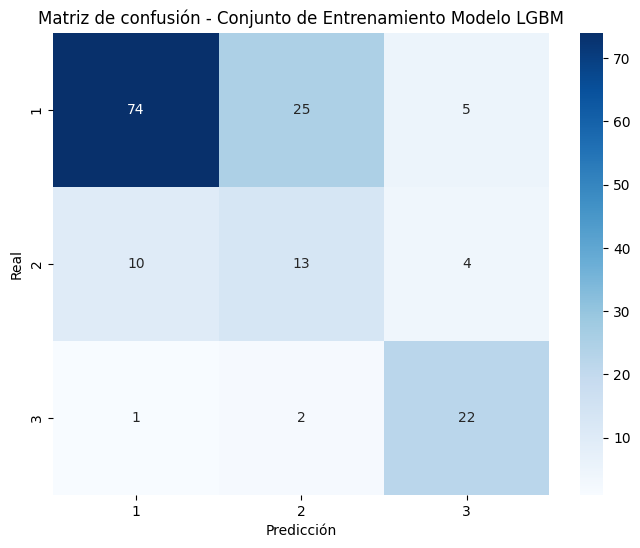

In [12]:
cm = confusion_matrix(y_train, y_test_pred_lgmb)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento Modelo LGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


MODELO CATBOOST 

In [13]:
catboost_model = CatBoostClassifier(random_state=42, silent=True)

param_dist_cat = {
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}
random_search_cat = RandomizedSearchCV(
    estimator=catboost_model, 
    param_distributions=param_dist_cat, 
    n_iter=20,  
    scoring='f1', 
    cv=5, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)


In [14]:
random_search_cat.fit(X_train_full, y_train_full)

y_pred_lgbm = random_search_cat.best_estimator_.predict(X_test_full)
print("Mejor hiperparámetro encontrado:", random_search_cat.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor hiperparámetro encontrado: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 4, 'border_count': 64}


In [15]:
y_test_blind_pred_cat = random_search_cat.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega con el modelo catboost:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred_cat):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")


Evaluación en conjunto de prueba ciega con el modelo catboost:
Accuracy: 0.6000
Precision: 0.6961
Recall: 0.6000
F1 Score: 0.6328


In [16]:
y_test_pred_cat = random_search_cat.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original con el modelo catboost:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred_cat):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred_cat, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred_cat, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred_cat, average='weighted'):.4f}")


Evaluación en conjunto train original con el modelo catboost:
Accuracy: 0.8718
Precision: 0.8834
Recall: 0.8718
F1 Score: 0.8759


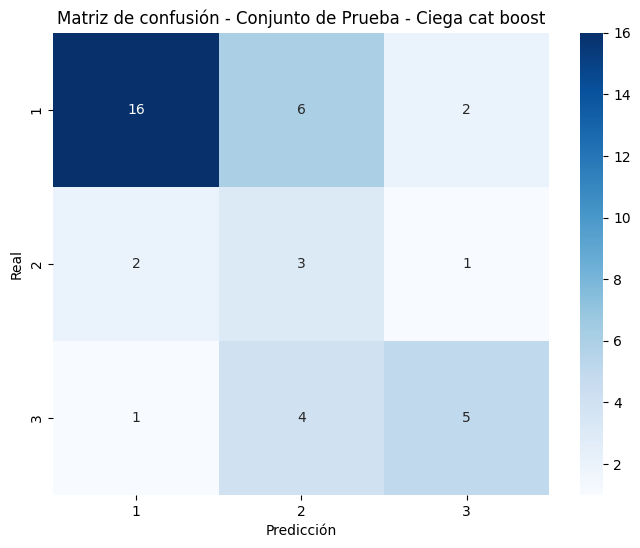

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba - Ciega cat boost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


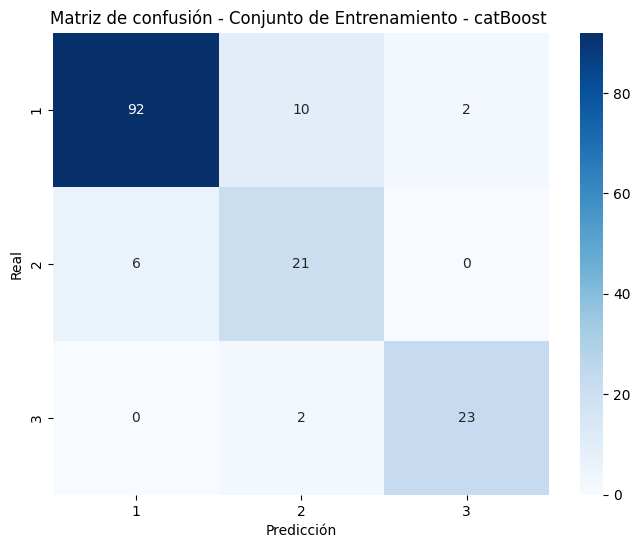

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento - catBoost ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()


Características más importantes en CatBoostClassifier:
Area Circulo                  15.489369
Circularidad                   8.655563
Manecilla 11 correcta          7.235750
longitud_relativa_11pm         5.985075
lowest_point_y                 5.802055
Round                          5.607696
Números con error espacial     5.130148
Manecillas diferentes          5.113843
longitud_relativa_2pm          4.753363
puntuacion final               4.188657
dtype: float64


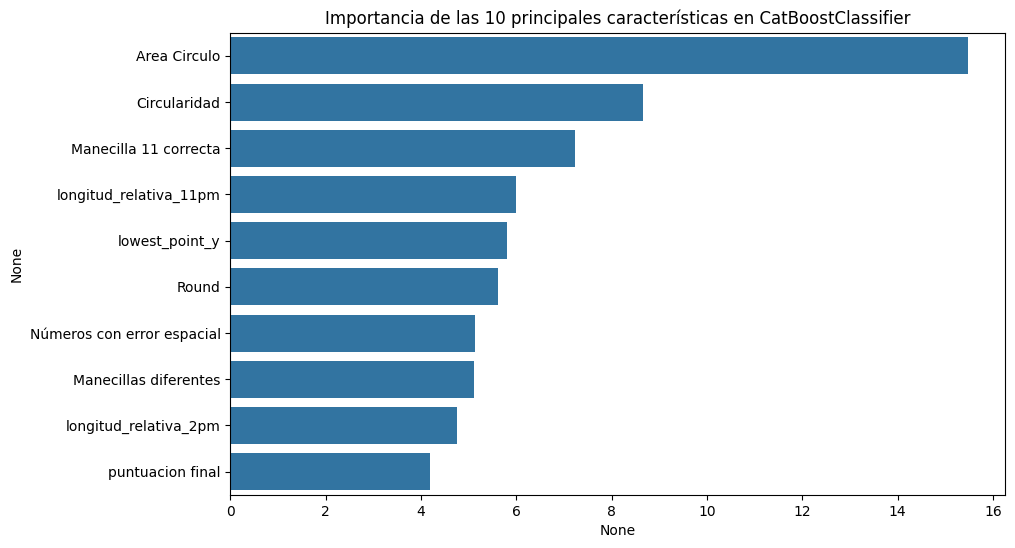

In [19]:
feature_importances = random_search_cat.best_estimator_.get_feature_importance()
importancias_catboost = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en CatBoostClassifier:")
print(importancias_catboost.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_catboost.head(10), y=importancias_catboost.index[:10])
plt.title("Importancia de las 10 principales características en CatBoostClassifier")
plt.show()

Características más importantes en LGBMClassifier:
Circularidad               77
Area Circulo               60
puntuacion final           51
Ángulo entre manecillas    43
Manecilla 11 correcta      37
Round                      35
longitud_relativa_11pm     32
Manecilla 2 correcta       27
Ángulo manecillas 11am     14
Puntuacion manecillas      12
dtype: int32


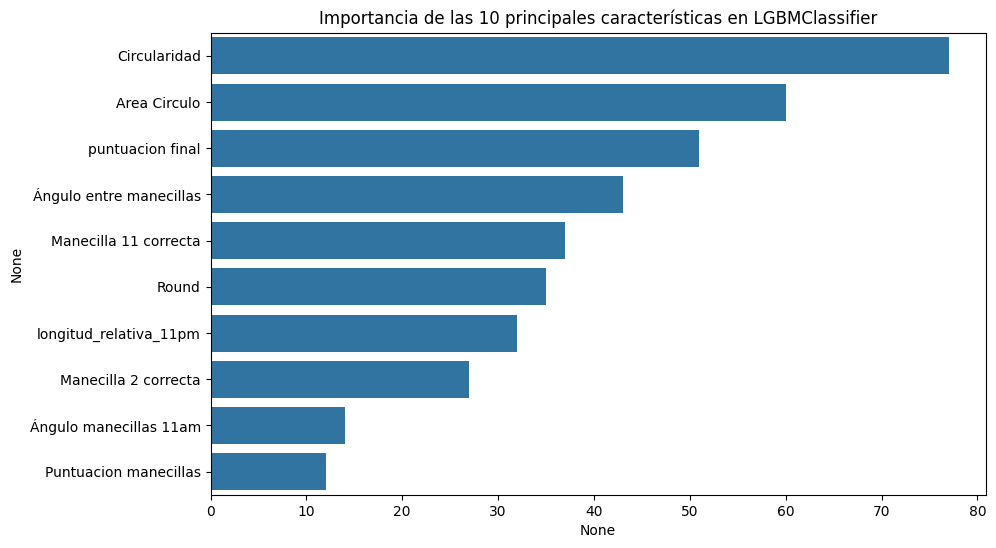

In [20]:
feature_importances = random_search_lgbm.best_estimator_.feature_importances_
importancias_lgb = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en LGBMClassifier:")
print(importancias_lgb.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_lgb.head(10), y=importancias_lgb.index[:10])
plt.title("Importancia de las 10 principales características en LGBMClassifier")
plt.show()

Características más importantes en CatBoostClassifier:
Area Circulo                  1.000000
Circularidad                  0.547217
Manecilla 11 correcta         0.453145
longitud_relativa_11pm        0.370280
lowest_point_y                0.358154
Round                         0.345276
Números con error espacial    0.313636
Manecillas diferentes         0.312555
longitud_relativa_2pm         0.288671
puntuacion final              0.251256
dtype: float64


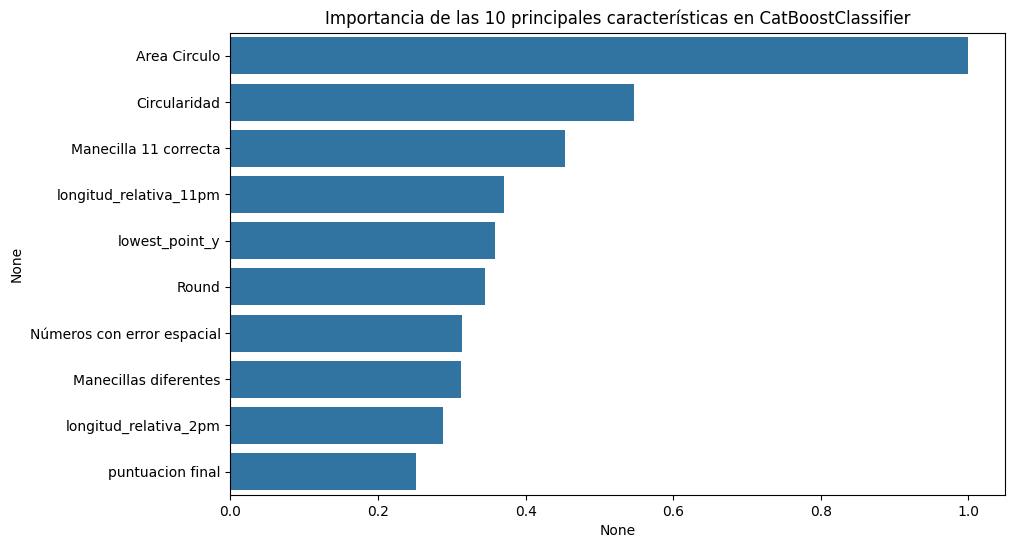

Características más importantes en LGBMClassifier:
Circularidad               1.000000
Area Circulo               0.779221
puntuacion final           0.662338
Ángulo entre manecillas    0.558442
Manecilla 11 correcta      0.480519
Round                      0.454545
longitud_relativa_11pm     0.415584
Manecilla 2 correcta       0.350649
Ángulo manecillas 11am     0.181818
Puntuacion manecillas      0.155844
dtype: float64


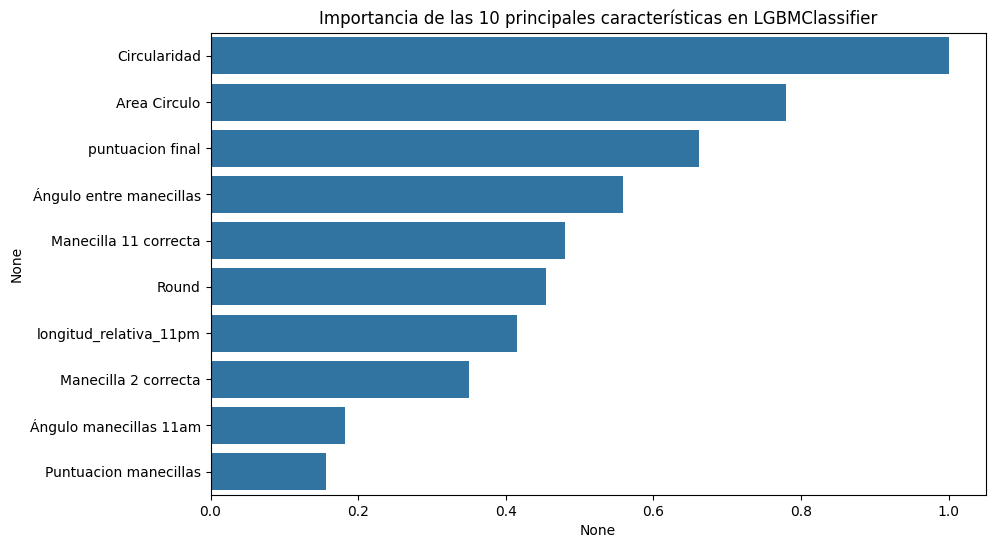

                            Variable  Importance_CatBoost  Importance_LGBM
0                       Area Circulo             1.000000         0.779221
1                       Circularidad             0.547217         1.000000
2              Manecilla 11 correcta             0.453145         0.480519
3               Manecilla 2 correcta             0.173729         0.350649
4              Manecillas diferentes             0.312555         0.155844
5             Números algo detectado             0.049218         0.000000
6         Números con error espacial             0.313636         0.129870
7   Números detectados correctamente             0.178057         0.064935
8                Puntuacion contorno             0.000000         0.000000
9              Puntuacion manecillas             0.189829         0.155844
10                Puntuacion numeros             0.212052         0.000000
11                             Round             0.345276         0.454545
12          Total numeros

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances_catboost = random_search_cat.best_estimator_.get_feature_importance()
importancias_catboost = pd.Series(feature_importances_catboost, index=X_train_full.columns)
importancias_catboost = (importancias_catboost - importancias_catboost.min()) / (importancias_catboost.max() - importancias_catboost.min())
importancias_catboost = importancias_catboost.sort_values(ascending=False)

print("Características más importantes en CatBoostClassifier:")
print(importancias_catboost.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=importancias_catboost.head(10), y=importancias_catboost.index[:10])
plt.title("Importancia de las 10 principales características en CatBoostClassifier")
plt.show()

df_importancias_catboost = pd.DataFrame({
    'Variable': importancias_catboost.index,
    'Importance_CatBoost': importancias_catboost.values
})

feature_importances_lgbm = random_search_lgbm.best_estimator_.feature_importances_
importancias_lgbm = pd.Series(feature_importances_lgbm, index=X_train_full.columns)
importancias_lgbm = (importancias_lgbm - importancias_lgbm.min()) / (importancias_lgbm.max() - importancias_lgbm.min())
importancias_lgbm = importancias_lgbm.sort_values(ascending=False)

print("Características más importantes en LGBMClassifier:")
print(importancias_lgbm.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=importancias_lgbm.head(10), y=importancias_lgbm.index[:10])
plt.title("Importancia de las 10 principales características en LGBMClassifier")
plt.show()

df_importancias_lgbm = pd.DataFrame({
    'Variable': importancias_lgbm.index,
    'Importance_LGBM': importancias_lgbm.values
})

df_final = pd.merge(df_importancias_catboost, df_importancias_lgbm, on='Variable', how='outer')

print(df_final)


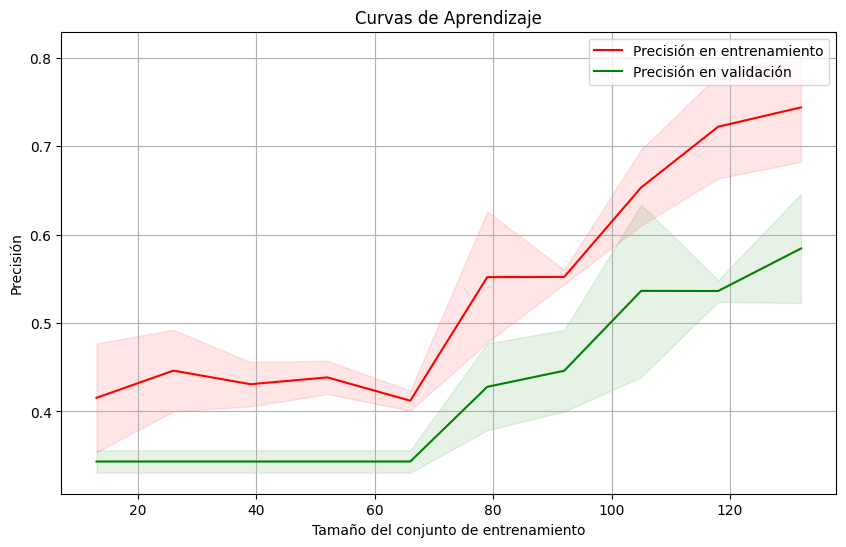

In [21]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    random_search_lgbm.best_estimator_, X_train_full, y_train_full, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Precisión en entrenamiento", color="r")
plt.plot(train_sizes, test_scores_mean, label="Precisión en validación", color="g")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="g", alpha=0.1)

# Títulos y etiquetas
plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid()
plt.show()

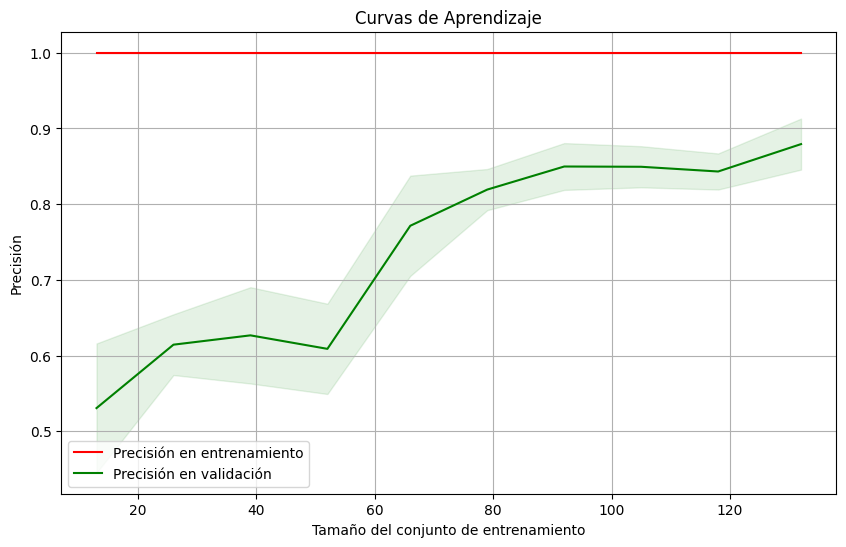

In [22]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    random_search_cat.best_estimator_, X_train_full, y_train_full, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Precisión en entrenamiento", color="r")
plt.plot(train_sizes, test_scores_mean, label="Precisión en validación", color="g")

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, color="g", alpha=0.1)

plt.title("Curvas de Aprendizaje")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Precisión")
plt.legend(loc="best")
plt.grid()
plt.show()

In [23]:
import joblib

joblib.dump(random_search_lgbm, 'lgb_model.pkl')

['lgb_model.pkl']

In [24]:
best_cat_model = random_search_cat.best_estimator_
best_cat_model.save_model('best_cat_model.cbm')


